In [ ]:
import re

fmriprep_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/data/bold/derivatives/fmriprep'
mot_params = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
sub_dirs = [ _ for _ in os.listdir(fmriprep_path) if 'sub' in _ and '.' not in _ ]
sub_dirs.sort()

flag = 'action'
# index quota required
quota = np.nanmedian
FD_sum = np.zeros((1))

for sub_dir in sub_dirs:
    ses_dirs = [_ for _ in os.listdir(pjoin(fmriprep_path, sub_dir)) if flag in _ and int(_[-2:])<2]
    ses_dirs.sort()
    for ses_dir in ses_dirs:
        files = [ _ for _ in os.listdir(pjoin(fmriprep_path, sub_dir, ses_dir, 'func')) if 'desc-confounds_timeseries.tsv' in _ \
                 and int(re.findall(r'run-\d+', _)[0].split('-')[-1])<=12]
        files.sort()
        for file in files:
            df = pd.read_csv(pjoin(fmriprep_path,f'{sub_dir}/{ses_dir}/func/{file}'), sep='\t')
            FD = np.sum(tuple([np.abs(df[_].values) for _ in mot_params]), axis=0)
            FD_index = np.array(quota(FD))[np.newaxis]
            # concatenate data
            FD_sum = np.concatenate((FD_sum, FD_index), axis=0)
    print(f'Finish {sub_dir} with {len(files)} runs')

# delete first value
FD_sum = np.delete(FD_sum, 0, axis=0).astype(np.float32)
label = np.repeat(sub_dirs, len(files))

In [ ]:

# merge data and label into df
df_FD = pd.DataFrame()
df_FD['FD'] = FD_sum
df_FD['Sub Name'] = label
plt.figure(figsize=(20, 6))

fig = sns.violinplot(x="Sub Name", y="FD", data=df_FD, color='grey', linewidth=2)
# fig.set_yticklabels(fig.get_yticks(), size = 15)
ax = plt.gca()
ax.set_ylim(-0.1, 2)
ax.set_xlim(-1,30)
ax.plot([-1,30], [0.5, 0.5], ls='--',color='#DD5353',lw=2)

ax.tick_params(labelsize=15, width=3, length=6, direction="in", pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.xticks(rotation=45)
plt.ylabel("Framewise Displacement (mm)", size=20, labelpad=15)
plt.xlabel("Sub Name", size=20, labelpad=15)

Finished computing smoothness estimates for sub-01 run 1
Finished computing smoothness estimates for sub-01 run 2
Finished computing smoothness estimates for sub-01 run 3
Finished computing smoothness estimates for sub-01 run 4
Finished computing smoothness estimates for sub-01 run 5
Finished computing smoothness estimates for sub-01 run 6
Finished computing smoothness estimates for sub-01 run 7
Finished computing smoothness estimates for sub-01 run 8
Finished computing smoothness estimates for sub-01 run 9
Finished computing smoothness estimates for sub-01 run 10
Finished computing smoothness estimates for sub-01 run 11
Finished computing smoothness estimates for sub-01 run 12
Finished computing smoothness estimates for sub-02 run 1
Finished computing smoothness estimates for sub-02 run 2
Finished computing smoothness estimates for sub-02 run 3
Finished computing smoothness estimates for sub-02 run 4
Finished computing smoothness estimates for sub-02 run 5
Finished computing smoothnes

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('#3d3d3d') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)


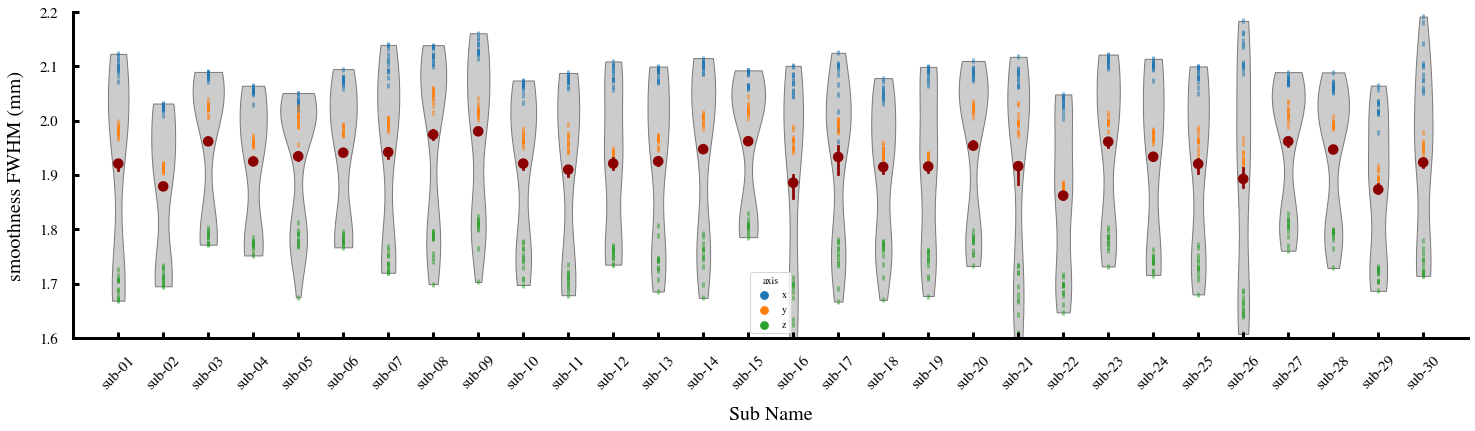

In [1]:
#!/usr/bin/env python3
# reference in https://github.com/snastase/narratives/blob/master/code/get_fwhm.py

from sys import argv
import os 
from os.path import basename, exists, join
from os import getcwd, remove
import pandas as pd
import numpy as np
from subprocess import run, PIPE

# Assign some directories
base_dir = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/'
beta_dir = join(base_dir, 'derivatives', 'beta')
prep_dir = join(base_dir, 'derivatives', 'fmriprep')

sub_names = sorted([i for i in os.listdir(beta_dir) if i.startswith('sub')])
fwhm, fwhm_sum, sub_label, axis = [], [], [], []

sub_names = sub_names
for sub_name in sub_names:
    sub_path = join(prep_dir, sub_name, 'ses-action01', 'func')
    for run_idx in range(12):
        bold_fn = join(sub_path, '%s_ses-action01_task-action_run-%d_space-T1w_desc-preproc_bold.nii.gz'%(sub_name, run_idx+1))
        mask_fn = join(sub_path, '%s_ses-action01_task-action_run-%d_space-T1w_desc-brain_mask.nii.gz'%(sub_name, run_idx+1))
        # Estimate FWHM from the original data
        orig_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {bold_fn} "
                        "-detrend -acf NULL -ShowMeClassicFWHM",
                        shell=True, stdout=PIPE)
        # Parse the smoothing output (X, Y, Z, combined)            
        fwhm_str = orig_fwhm.stdout.decode('utf-8').partition('\n')[0]
        fwhm_tmp = [float(s) for s in fwhm_str.split(' ') if s not in [' ', '']]
        # save fwhm into containers
        fwhm.extend(fwhm_tmp[:3])
        fwhm_sum.append(fwhm_tmp[-1])
        axis.extend(['x', 'y', 'z'])
        print(f"Finished computing smoothness estimates for {sub_name} run {run_idx+1}")

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# merge data and label into df
df_fwhm = pd.DataFrame()
df_fwhm['fwhm'] = fwhm
df_fwhm['axis'] = axis
df_fwhm['Sub Name'] = np.repeat(sub_names, 12*3)
# another df
df_fwhm_com = pd.DataFrame()
df_fwhm_com['fwhm'] = fwhm_sum
df_fwhm_com['Sub Name'] = np.repeat(sub_names, 12)
plt.figure(figsize=(25, 6))

fig = sns.violinplot(x="Sub Name", y="fwhm", data=df_fwhm, color='.8', 
        inner=None, linewidth=1, cut=0, zorder=0)
sns.stripplot(x='Sub Name', y='fwhm', hue='axis', data=df_fwhm, jitter=False, size=5, 
        marker='|', linewidth=3, alpha=.5, zorder=1, )
sns.pointplot(x='Sub Name', y='fwhm', data=df_fwhm_com, join=False, scale=1.2, color='darkred', 
        errorbar=False, estimator=np.median, legend=False)

ax = plt.gca()
ax.set_ylim(1.6, 2.2)
ax.set_xlim(-1,30)
ax.plot([-1,30], [0.5, 0.5], ls='--',color='#DD5353',lw=2)

ax.tick_params(labelsize=15, width=3, length=6, direction="in", pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.xticks(rotation=45)
plt.ylabel("smoothness FWHM (mm)", size=20, labelpad=15)
plt.xlabel("Sub Name", size=20, labelpad=15)
plt.savefig('/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result/fwhm_tmp.jpg')



/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('#3d3d3d') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)


Text(0.5, 0, 'Sub Name')

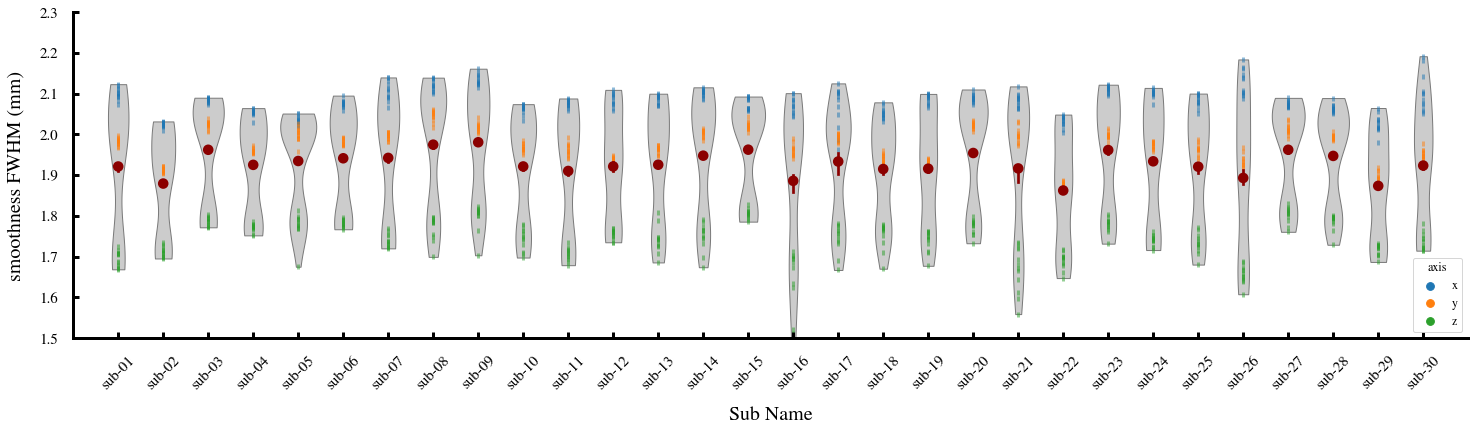

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# merge data and label into df
df_fwhm = pd.DataFrame()
df_fwhm['fwhm'] = fwhm
df_fwhm['axis'] = axis
df_fwhm['Sub Name'] = np.repeat(sub_names, 12*3)
# another df
df_fwhm_com = pd.DataFrame()
df_fwhm_com['fwhm'] = fwhm_sum
df_fwhm_com['Sub Name'] = np.repeat(sub_names, 12)
plt.figure(figsize=(25, 6))

fig = sns.violinplot(x="Sub Name", y="fwhm", data=df_fwhm, color='.8', 
        inner=None, linewidth=1, cut=0, zorder=0)
sns.stripplot(x='Sub Name', y='fwhm', hue='axis', data=df_fwhm, jitter=False, size=5, 
        marker='|', linewidth=3, alpha=.5, zorder=1, )
sns.pointplot(x='Sub Name', y='fwhm', data=df_fwhm_com, join=False, scale=1.2, color='darkred', 
        errorbar=False, estimator=np.median, legend=False)

ax = plt.gca()
ax.set_ylim(1.5, 2.3)
ax.set_xlim(-1,30)
ax.plot([-1,30], [0.5, 0.5], ls='--',color='#DD5353',lw=2)

ax.tick_params(labelsize=15, width=3, length=6, direction="in", pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.xticks(rotation=45)
plt.ylabel("smoothness FWHM (mm)", size=20, labelpad=15)
plt.xlabel("Sub Name", size=20, labelpad=15)
# plt.savefig('/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result/fwhm.jpg')
